In [1]:
from __future__ import print_function
import keras
# from keras.callbacks import Tensorboard #传说可以可视化------------------->????????????????
from keras.models import Sequential
from keras.layers import LSTM
from keras.models import Model
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Embedding, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Reshape
from keras.layers import Input, Add, Dense, Activation
from keras.layers import Flatten
from sklearn.cross_validation import train_test_split
from keras.layers import  BatchNormalization,TimeDistributed
from keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

E:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# #得到数据，从一个文件夹中得到力信号 振动信号 声发射信号
def get_data(file,num):
    data_all= pd.read_csv(file,header = None,error_bad_lines=False)
    Force_x     = data_all[0]
    Force_y     = data_all[1]
    Force_z     = data_all[2]
    vibration_x = data_all[3]
    vibration_y = data_all[4]
    vibration_z = data_all[5]
    AE_RMS      = data_all[6]
    # 数据截取
    Force_x     = np.array(Force_x).reshape(1,-1)
    Force_y     = np.array(Force_y).reshape(1,-1)
    Force_z     = np.array(Force_z).reshape(1,-1)
    vibration_x = np.array(vibration_x).reshape(1,-1)
    vibration_y = np.array(vibration_y).reshape(1,-1)
    vibration_z = np.array(vibration_z).reshape(1,-1)
    AE_RMS      = np.array(AE_RMS).reshape(1,-1)
    # 标准化处理
    Force_x_score1 = (Force_x - np.mean(Force_x)) / np.std(Force_x)
    Force_y_score1 = (Force_y - np.mean(Force_y)) / np.std(Force_y)
    Force_z_score1 = (Force_z - np.mean(Force_z)) / np.std(Force_z)
    vibration_x_score1 = (vibration_x - np.mean(vibration_x)) / np.std(vibration_x)
    vibration_y_score1 = (vibration_y - np.mean(vibration_y)) / np.std(vibration_y)
    vibration_z_score1 = (vibration_z - np.mean(vibration_z)) / np.std(vibration_z)
    AE_RMS_score1 = (AE_RMS - np.mean(AE_RMS)) / np.std(AE_RMS)
    
    #取信号长度为210000个点
    if len(Force_x_score1[0])<num:
        Force_x = np.hstack((Force_x_score1,Force_x_score1))
    if len(Force_x_score1[0])>num:
        Force_x = Force_x_score1[:,num:num*2]
#     print(len(Force_x[0]))
    
    if len(Force_y_score1[0])<num:
        Force_y = np.hstack((Force_y_score1,Force_y_score1))
    if len(Force_y_score1[0])>num:
        Force_y=Force_y_score1[:,num:num*2]
#     print(len(Force_y[0]))
    
    if len(Force_z_score1[0])<num:
        Force_z = np.hstack((Force_z_score1,Force_z_score1))
    if len(Force_z_score1[0])>num:
        Force_z = Force_z_score1[:,num:num*2]
#     print(len(Force_z[0]))
    
    if len(vibration_x_score1[0])<num:
        vibration_x = np.hstack((vibration_x_score1,vibration_x_score1))
    if len(vibration_x_score1[0])>num:
        vibration_x = vibration_x_score1[:,num:num*2]
#     print(len(vibration_x[0]))
    
    if len(vibration_y_score1[0])<num:
        vibration_y = np.hstack((vibration_y_score1,vibration_y_score1))
    if len(vibration_y_score1[0])>num:
        vibration_y = vibration_y_score1[:,num:num*2]
#     print(len(vibration_y[0]))
    
    if len(vibration_z_score1[0])<num:
        vibration_z = np.hstack((vibration_z_score1,vibration_z_score1))
    if len(vibration_z_score1[0])>num:
        vibration_z = vibration_z_score1[:,num:num*2]
#     print(len(vibration_z[0]))
    
    if len(AE_RMS_score1[0])<num:
        AE_RMS = np.hstack((AE_RMS_score1,AE_RMS_score1))
    if len(AE_RMS_score1[0])>num:
        AE_RMS=AE_RMS_score1[:,num:num*2]
#     print(len(AE_RMS[0]))
    
    data=np.vstack((Force_x,Force_y,Force_z,vibration_x,vibration_y,vibration_z,AE_RMS))
#     print(data.shape,'3')
    data=np.array(data)
#     print(data.shape,'1')
    data=data.reshape(-1,7,num)
#     print(data.shape,'2')
    return data

b=get_data(r'G:\big-data-train_industry\PHM 2010\c4\c4\c_4_001.csv')

np.shape(b)

In [8]:
# y_data= pd.read_csv(r'E:\c1\c1_wear.csv',header = None)
y1 = pd.read_csv(filepath_or_buffer = r'G:\big-data-train_industry\PHM 2010\c1\c1_wear.csv', sep = ',')["flute_1"].values
print(y1)
os.chdir(r'G:\big-data-train_industry\PHM 2010\c1\c1')
# #     #设置当前环境路径
filename_list1=[]
filename_list1=os.listdir(r'G:\big-data-train_industry\PHM 2010\c1\c1')
print(filename_list1)
# file_list_1=['c_1_001.csv','c_1_002.csv']

[ 32.31711361  37.914879    43.08790971  47.8590723   52.25032922
  56.28276562  59.97661561  63.3512879   66.4253909   69.21675719
  71.74246752  74.01887416  76.06162381  77.88567991  79.50534445
  80.93427925  82.18552678  83.27153045  84.20415441  84.99470288
  85.653939    86.19210327  86.61893145  86.94367205  87.17510345
  87.32155046  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090058  87.39090058  87.39090058  87.39090058  87.39090058
  87.39090

In [9]:
# y_data= pd.read_csv(r'E:\c1\c1_wear.csv',header = None)
y4 = pd.read_csv(filepath_or_buffer = r'G:\big-data-train_industry\PHM 2010\c4\c4_wear.csv', sep = ',')["flute_1"].values
print(y4)
os.chdir(r'G:\big-data-train_industry\PHM 2010\c4\c4')
# #     #设置当前环境路径
filename_list4=[]
filename_list4=os.listdir(r'G:\big-data-train_industry\PHM 2010\c4\c4')
print(filename_list4)
# file_list_1=['c_1_001.csv','c_1_002.csv']

[ 31.41635516  34.8927704   38.10284657  41.06102301  43.78119133
  46.27671037  48.56042098  50.64466037  52.54127629  54.26164088
  55.81666418  57.21680745  58.47209617  59.59213275  60.58610902
  61.46281844  62.23066801  62.89769001  63.47155339  63.959575
  64.36873051  64.70566514  64.9767041   65.1878629   65.34485725
  65.45311297  65.51777545  65.54371906  65.54371906  65.54371906
  65.54371906  65.54371906  65.54371906  65.54371906  65.54371906
  65.54371906  65.54371906  65.54371906  65.54371906  65.54371906
  65.54371906  65.54371906  65.54371906  65.54371906  65.54371906
  65.54371906  65.54371906  65.54371906  65.54371906  65.54371906
  65.54371906  65.54371906  65.54371906  65.54371906  65.54371906
  65.54371906  65.54371906  65.54371906  65.54371906  65.54371906
  65.54371906  65.54371906  65.54371906  65.54371906  65.54371906
  65.54371906  65.58464803  65.89045864  66.21371695  66.55393858
  66.9106077   67.28317974  67.67108395  68.07372593  68.49049008
  68.9207418

In [10]:
# y_data= pd.read_csv(r'E:\c1\c1_wear.csv',header = None)
y6 = pd.read_csv(filepath_or_buffer = r'G:\big-data-train_industry\PHM 2010\c6\c6_wear.csv', sep = ',')["flute_1"].values
print(y6)
os.chdir(r'G:\big-data-train_industry\PHM 2010\c6\c6')
# #     #设置当前环境路径
filename_list6=[]
filename_list6=os.listdir(r'G:\big-data-train_industry\PHM 2010\c6\c6')
print(filename_list6)
# file_list_1=['c_1_001.csv','c_1_002.csv']

[ 62.78864802  64.13604296  65.36527295  66.4868801   67.51080822
  68.44642494  69.30254323  70.08744241  70.8088887   71.47415519
  72.09004135  72.66289207  73.19861618  73.70270453  74.18024756
  74.63595243  75.07415974  75.4988597   75.91370798  76.32204104
  76.72689103  77.13100039  77.53683587  77.94660226  78.36225568
  78.78551648  79.21788179  79.66063762  80.11487062  80.58147952
  81.06118616  81.55454615  82.06195924  82.58367929  83.11982397
  83.67038407  84.23523251  84.81413304  85.40674866  86.01264963
  86.63132132  87.26217167  87.90453839  88.55769588  89.22086191
  89.89320394  90.57384526  91.26187086  91.956333    92.65625657
  93.36064421  94.06848117  94.77873996  95.49038474  96.20237554
  96.91367223  97.62323828  98.33004431  99.03307145  99.73131453
 100.423785   101.1095138  101.7875539  102.4569826  103.1169041
 103.7664512  104.4047877  105.0311097  105.6446474  106.2446665
 106.8304699  107.4013983  107.9568315  108.4961893  109.0189324
 109.524563  

In [11]:
os.chdir(r'G:\big-data-train_industry\PHM 2010\c1\c1')
i=0
x1=[]
x1=np.array(x1)
x1 = x1.reshape(-1,7, 25600)
for name in filename_list1:
    X_linshi = get_data(name,25600)
    x1 = np.vstack((x1,X_linshi))
    i=i+1
    print(x1.shape,i)

(1, 7, 25600) 1
(2, 7, 25600) 2
(3, 7, 25600) 3
(4, 7, 25600) 4
(5, 7, 25600) 5
(6, 7, 25600) 6
(7, 7, 25600) 7
(8, 7, 25600) 8
(9, 7, 25600) 9
(10, 7, 25600) 10
(11, 7, 25600) 11
(12, 7, 25600) 12
(13, 7, 25600) 13
(14, 7, 25600) 14
(15, 7, 25600) 15
(16, 7, 25600) 16
(17, 7, 25600) 17
(18, 7, 25600) 18
(19, 7, 25600) 19
(20, 7, 25600) 20
(21, 7, 25600) 21
(22, 7, 25600) 22
(23, 7, 25600) 23
(24, 7, 25600) 24
(25, 7, 25600) 25
(26, 7, 25600) 26
(27, 7, 25600) 27
(28, 7, 25600) 28
(29, 7, 25600) 29
(30, 7, 25600) 30
(31, 7, 25600) 31
(32, 7, 25600) 32
(33, 7, 25600) 33
(34, 7, 25600) 34
(35, 7, 25600) 35
(36, 7, 25600) 36
(37, 7, 25600) 37
(38, 7, 25600) 38
(39, 7, 25600) 39
(40, 7, 25600) 40
(41, 7, 25600) 41
(42, 7, 25600) 42
(43, 7, 25600) 43
(44, 7, 25600) 44
(45, 7, 25600) 45
(46, 7, 25600) 46
(47, 7, 25600) 47
(48, 7, 25600) 48
(49, 7, 25600) 49
(50, 7, 25600) 50
(51, 7, 25600) 51
(52, 7, 25600) 52
(53, 7, 25600) 53
(54, 7, 25600) 54
(55, 7, 25600) 55
(56, 7, 25600) 56
(57, 7, 25

print(x1.shape)

In [12]:
os.chdir(r'G:\big-data-train_industry\PHM 2010\c4\c4')
i=0
x4=[]
x4=np.array(x4)
x4 = x4.reshape(-1,7, 25600)
for name in filename_list4:
    X_linshi = get_data(name,25600)
    x4 = np.vstack((x4,X_linshi))
    i=i+1
    print(x4.shape,i)

(1, 7, 25600) 1
(2, 7, 25600) 2
(3, 7, 25600) 3
(4, 7, 25600) 4
(5, 7, 25600) 5
(6, 7, 25600) 6
(7, 7, 25600) 7
(8, 7, 25600) 8
(9, 7, 25600) 9
(10, 7, 25600) 10
(11, 7, 25600) 11
(12, 7, 25600) 12
(13, 7, 25600) 13
(14, 7, 25600) 14
(15, 7, 25600) 15
(16, 7, 25600) 16
(17, 7, 25600) 17
(18, 7, 25600) 18
(19, 7, 25600) 19
(20, 7, 25600) 20
(21, 7, 25600) 21
(22, 7, 25600) 22
(23, 7, 25600) 23
(24, 7, 25600) 24
(25, 7, 25600) 25
(26, 7, 25600) 26
(27, 7, 25600) 27
(28, 7, 25600) 28
(29, 7, 25600) 29
(30, 7, 25600) 30
(31, 7, 25600) 31
(32, 7, 25600) 32
(33, 7, 25600) 33
(34, 7, 25600) 34
(35, 7, 25600) 35
(36, 7, 25600) 36
(37, 7, 25600) 37
(38, 7, 25600) 38
(39, 7, 25600) 39
(40, 7, 25600) 40
(41, 7, 25600) 41
(42, 7, 25600) 42
(43, 7, 25600) 43
(44, 7, 25600) 44
(45, 7, 25600) 45
(46, 7, 25600) 46
(47, 7, 25600) 47
(48, 7, 25600) 48
(49, 7, 25600) 49
(50, 7, 25600) 50
(51, 7, 25600) 51
(52, 7, 25600) 52
(53, 7, 25600) 53
(54, 7, 25600) 54
(55, 7, 25600) 55
(56, 7, 25600) 56
(57, 7, 25

In [14]:
os.chdir(r'G:\big-data-train_industry\PHM 2010\c6\c6')
i=0
x6=[]
x6=np.array(x6)
x6 = x6.reshape(-1,7, 25600)
for name in filename_list6:
    X_linshi = get_data(name,25600)
    x6 = np.vstack((x6,X_linshi))
    i=i+1
    print(x6.shape,i)

(1, 7, 25600) 1
(2, 7, 25600) 2
(3, 7, 25600) 3
(4, 7, 25600) 4
(5, 7, 25600) 5
(6, 7, 25600) 6
(7, 7, 25600) 7
(8, 7, 25600) 8
(9, 7, 25600) 9
(10, 7, 25600) 10
(11, 7, 25600) 11
(12, 7, 25600) 12
(13, 7, 25600) 13
(14, 7, 25600) 14
(15, 7, 25600) 15
(16, 7, 25600) 16
(17, 7, 25600) 17
(18, 7, 25600) 18
(19, 7, 25600) 19
(20, 7, 25600) 20
(21, 7, 25600) 21
(22, 7, 25600) 22
(23, 7, 25600) 23
(24, 7, 25600) 24
(25, 7, 25600) 25
(26, 7, 25600) 26
(27, 7, 25600) 27
(28, 7, 25600) 28
(29, 7, 25600) 29
(30, 7, 25600) 30
(31, 7, 25600) 31
(32, 7, 25600) 32
(33, 7, 25600) 33
(34, 7, 25600) 34
(35, 7, 25600) 35
(36, 7, 25600) 36
(37, 7, 25600) 37
(38, 7, 25600) 38
(39, 7, 25600) 39
(40, 7, 25600) 40
(41, 7, 25600) 41
(42, 7, 25600) 42
(43, 7, 25600) 43
(44, 7, 25600) 44
(45, 7, 25600) 45
(46, 7, 25600) 46
(47, 7, 25600) 47
(48, 7, 25600) 48
(49, 7, 25600) 49
(50, 7, 25600) 50
(51, 7, 25600) 51
(52, 7, 25600) 52
(53, 7, 25600) 53
(54, 7, 25600) 54
(55, 7, 25600) 55
(56, 7, 25600) 56
(57, 7, 25

In [25]:
#   有效的
def TDcnn2d():
    input_shape = (10,7,2560,1)
    X_input = Input(input_shape)
    X = TimeDistributed(keras.layers.Conv2D(filters=10, kernel_size=(1,128), strides=(1,4),activation='relu'))(X_input)
    X = BatchNormalization(epsilon=1e-06, mode=0, axis=4, momentum=0.9, weights=None, beta_init='zero',gamma_init='one')(X)
    X = TimeDistributed(keras.layers.AveragePooling2D(pool_size=(1, 2)))(X)
    
    X = TimeDistributed(keras.layers.Conv2D(filters=5, kernel_size=(1,10), strides=(1,4),activation='relu'))(X)
    X = BatchNormalization(epsilon=1e-06, mode=0, axis=4, momentum=0.9, weights=None, beta_init='zero',gamma_init='one')(X)
    X = TimeDistributed(keras.layers.AveragePooling2D(pool_size=(1, 2)))(X)
    
    X = TimeDistributed(keras.layers.Conv2D(filters=1, kernel_size=(1,4), strides=(1,4),activation='relu'))(X)
    X = BatchNormalization(epsilon=1e-06, mode=0, axis=4, momentum=0.9, weights=None, beta_init='zero',gamma_init='one')(X)
    X = TimeDistributed(keras.layers.AveragePooling2D(pool_size=(1, 2)))(X)
#     X = TimeDistributed(Flatten())(X)
#     X = LSTM(5)(X)
#     X = Flatten()(X)
#     X = LSTM(10)(X)
    X = keras.layers.Reshape((1, -1))(X)
    X = Flatten()(X)
#     X = Dense(100)(X)
#     X = Dense(10)(X)
    X = Dense(1)(X)
    model = Model(inputs=X_input, outputs=X, name='xmd1207')
    return model


In [26]:
model = TDcnn2d()
model.compile(optimizer='adam', loss='msle')
model.summary()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=4, momentum=0.9, weights=None, beta_initializer="zero", gamma_initializer="one")`
  
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=4, momentum=0.9, weights=None, beta_initializer="zero", gamma_initializer="one")`
  # Remove the CWD from sys.path while we load stuff.
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=4, momentum=0.9, weights=None, beta_initializer="zero", gamma_initializer="one")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10, 7, 2560, 1)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 10, 7, 609, 10)    1290      
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 7, 609, 10)    40        
_________________________________________________________________
time_distributed_25 (TimeDis (None, 10, 7, 304, 10)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10, 7, 74, 5)      505       
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 7, 74, 5)      20        
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 7, 37, 5)      0         
__________

In [35]:
x1=x1.reshape(-1,10,7,2560,1)
x4=x4.reshape(-1,10,7,2560,1)
x6=x6.reshape(-1,10,7,2560,1)
y1=y1.reshape(-1,1)
y4=y4.reshape(-1,1)
y6=y6.reshape(-1,1)
x_train=np.vstack((x1,x4))
y_train=np.vstack((y1,y4))



In [37]:
x1.shape

(315, 10, 7, 2560, 1)

In [53]:
# a=model.fit(x_train, y_train, epochs=100, validation_split=0.2, validation_data=None,batch_size=10,verbose=1)
a=model.fit(x_train, y_train, epochs=10, validation_split=0, validation_data=(x6,y6),batch_size=10,verbose=1)

Train on 630 samples, validate on 315 samples
Epoch 1/10
630/630 [==============================] - 73s 115ms/step - loss: 0.0033 - val_loss: 0.3658
Epoch 2/10
630/630 [==============================] - 73s 116ms/step - loss: 0.0033 - val_loss: 0.1607
Epoch 3/10
630/630 [==============================] - 75s 120ms/step - loss: 0.0036 - val_loss: 0.2114
Epoch 4/10
630/630 [==============================] - 75s 120ms/step - loss: 0.0031 - val_loss: 0.2937
Epoch 5/10
630/630 [==============================] - 75s 120ms/step - loss: 0.0034 - val_loss: 0.1901
Epoch 6/10
630/630 [==============================] - 76s 120ms/step - loss: 0.0034 - val_loss: 0.2496
Epoch 7/10
630/630 [==============================] - 76s 120ms/step - loss: 0.0026 - val_loss: 0.2840
Epoch 8/10
630/630 [==============================] - 75s 120ms/step - loss: 0.0028 - val_loss: 0.2363
Epoch 9/10
630/630 [==============================] - 76s 120ms/step - loss: 0.0025 - val_loss: 0.2466
Epoch 10/10
630/630 [======

In [54]:
yhat = model.predict(x6, verbose=1)

315/315 [==============================] - 11s 33ms/step


(1, 315)
(1, 315)


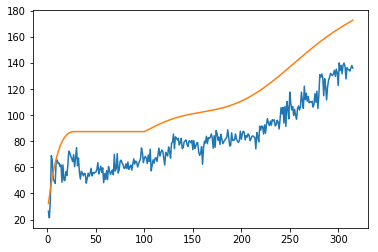

In [55]:
yhat = model.predict(x6, verbose=1)
yhat=yhat.reshape(1,-1)
y1=y1.reshape(1,-1)
print(yhat.shape)
print(y1.shape)
x_line= np.linspace(1,len(yhat[0]),len(yhat[0]))

plt.figure(1)
plt.plot(x_line,yhat[0],x_line,y1[0])

In [15]:
#   有效的
def cnn():
    input_shape = (7,20480,1)
    X_input = Input(input_shape)
    X = TimeDistributed(Conv1D(filters=10, kernel_size=20, strides=4,activation='relu'))(X_input)
    X = BatchNormalization(epsilon=1e-06, mode=0, axis=3, momentum=0.9, weights=None, beta_init='zero',gamma_init='one')(X)
    X = TimeDistributed(keras.layers.pooling.AveragePooling1D(pool_size=2))(X)
    X = TimeDistributed(Conv1D(filters=5, kernel_size=10, strides=4,activation='relu'))(X)
    X = BatchNormalization(epsilon=1e-06, mode=0, axis=3, momentum=0.9, weights=None, beta_init='zero',gamma_init='one')(X)
    X = TimeDistributed(keras.layers.pooling.AveragePooling1D(pool_size=2))(X)
    X = TimeDistributed(Flatten())(X)
#     X = LSTM(5)(X)
#     X = Flatten()(X)
#     X = LSTM(10)(X)
    X = keras.layers.Reshape((1, -1))(X)
    X = Flatten()(X)
    X = Dense(1)(X)
    model = Model(inputs=X_input, outputs=X, name='xmd1207')
    return model


In [16]:
def inception_CNN():

    input_shape=(7,20480,1)
    img_input = layers.Input(shape=input_shape)

    drop=0.2

    x = layers.Conv2D(32, (1, 256), strides=1, use_bias=False, padding='same', name='conv1/conv')(img_input)
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    
    x = layers.MaxPooling2D((1, 2), strides=(1, 2), padding='same', name='pool1')(x)
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_0_bn')(x)   
    x = layers.Activation('relu', name=name + '_0_relu')(x)
        

    x1 = layers.Conv2D(4, (1, 32), use_bias=False, padding='same', name=name + '_1_conv')(x)

    x1 = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_1_bn')(x1)

    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
        
 

    x2 = layers.Conv2D(4, (1, 64), use_bias=False, padding='same', name=name + '_1_conv')(x)

    x2 = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_1_bn')(x2)

    x2 = layers.Activation('relu', name=name + '_1_relu')(x2)
    

    out  = layers.Concatenate(axis=3, name=name + '_concat')([x, x1,x2])
    model = Model(inputs=img_input, outputs=out)
    return model

In [17]:
from keras.layers import ConvLSTM2D,MaxPooling3D
def ConvLstm():
    input_shape = Input(shape=(40,512,7,1))
    print('building model...')
    x=ConvLSTM2D(filters=1,kernel_size=(60,3),padding='valid',return_sequences=True)(input_shape)
    x=BatchNormalization(axis=1)(x)
    x=Activation('relu')(x)
    x=MaxPooling3D(pool_size=(1,2,1),strides=None,padding='valid',data_format=None)(x)
    
    x=ConvLSTM2D(filters=1,kernel_size=(6,5),padding='valid',return_sequences=True)(x)
    x=BatchNormalization(axis=1)(x)
    x=Activation('relu')(x)
    x=MaxPooling3D(pool_size=(1,2,1),strides=None,padding='valid',data_format=None)(x)
    
    x=ConvLSTM2D(filters=1,kernel_size=(6,1),padding='valid',return_sequences=True)(x)
    x=BatchNormalization(axis=1)(x)
    x=Activation('relu')(x)
    
    x=Reshape((40,-1))(x)
    x=LSTM(10,return_sequences=True)(x)
    x=BatchNormalization(axis=1)(x)
    x=Activation('relu')(x)
    
    x=LSTM(1,activation='relu',return_sequences=True)(x)
    x=Flatten()(x)
    x=Dense(1,activation='relu')(x)
    y=Dense(1,activation='relu')(x)
    model = Model(inputs=input_shape, outputs=y, name='xmd1207')
    return model

    

In [40]:
# x_train = x[              :4*len(x)//5]
# x_test  = x[ 4*len(x)//5:             ]
# y_train = y[              :4*len(x)//5]
# y_test  = y[ 4*len(x)//5:             ]
# x_train1 = x1[              :250]
# x_test1  = x1[250:             ]
# y_train1 = y1[              :250]
# y_test1  = y1[250:             ]

# x_train = x_train.reshape(50,5,210000,1)
# x_test  = x_test.reshape(13,5,210000,1)
# x  = x.reshape(63,5,210000,1)
# y_train = y_train.reshape(50,5,1)
# y_test = y_test.reshape(13,5,1)
# y  = y.reshape(63,5,1)
#==========================================打乱数据 
# np.random.seed(116)
# np.random.shuffle(data) 
# np.random.seed(116)
# np.random.shuffle(y) 

x1=x1.reshape(-1,7,20480,1)
y1=y1.reshape(-1,1)

x4=x4.reshape(-1,7,20480,1)
y4=y4.reshape(-1,1)

x6=x6.reshape(-1,7,20480,1)
y6=y6.reshape(-1,1)

# #     标准化处理
# x_Z_score1 = (x1 - np.mean(x1)) / np.std(x1)
# print('x_Z_score1')
# x_Z_score4 = (x4 - np.mean(x4)) / np.std(x4)
# print('x_Z_score1')
# x_Z_score6 = (x6 - np.mean(x6)) / np.std(x6)
# print('x_Z_score1')
# #==========================================打乱数据
# x1=x1.reshape(-1,7,20480,1)
# y1=y1.reshape(-1,1)
# np.random.seed(110)
# np.random.shuffle(x1) 
# np.random.seed(110)
# np.random.shuffle(y1) 

# x4=x4.reshape(-1,7,20480,1)
# y4=y4.reshape(-1,1)
# np.random.seed(116)
# np.random.shuffle(x4) 
# np.random.seed(116)
# np.random.shuffle(y4) 

# x6=x6.reshape(-1,7,20480,1)
# y6=y6.reshape(-1,1)
# np.random.seed(1163)
# np.random.shuffle(x6) 
# np.random.seed(1163)
# np.random.shuffle(y6) 

x_Z_score1
x_Z_score1
x_Z_score1


In [45]:
for i in range (315):
    a=x6[i].std()

#     a=x6[i].max()-x1[i].min()
    print(a)

0.7227881685089976
1.8044219147542513
2.7138360318403003
3.109139984852592
3.04669116592137
3.371351831180819
3.2083308840330576
3.2964688437037437
3.6768583054252764
3.9487803756871553
3.7285965547409043
3.8339122428884513
3.7183117164983344
3.7964829824573174
3.8299562982118616
3.8842706715162367
3.9817815799721807
4.016229353962349
3.745420308693291
3.776615696687283
4.185328282460261
4.377992422379115
4.431333141922449
4.538713283773547
4.576755856592362
4.5520750830077885
4.633984726557602
4.643662154167642
4.659977141699549
4.770353563347461
4.223498032466418
4.231863386429916
4.447969070047758
4.6111494751865125
4.686430810845984
4.676628756379805
4.709579277044658
4.746796850445257
4.779583101140026
4.839206333362367
4.822933670857211
4.886994319447839
4.941183430217518
4.992287669123677
5.0123375701459025
5.130320646107809
4.553164285510239
5.14880491463824
5.200545804551846
5.204207164683437
5.230633583186348
5.282603666527973
5.3070363666401486
5.264146312288944
5.4134177317

In [32]:
print(a)

0.805357258052031


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=3, momentum=0.9, weights=None, beta_initializer="zero", gamma_initializer="one")`
  
E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=3, momentum=0.9, weights=None, beta_initializer="zero", gamma_initializer="one")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7, 20480, 1)       0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 7, 5116, 10)       210       
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 5116, 10)       40        
_________________________________________________________________
time_distributed_17 (TimeDis (None, 7, 2558, 10)       0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 7, 638, 5)         505       
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 638, 5)         20        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 7, 319, 5)         0         
__________

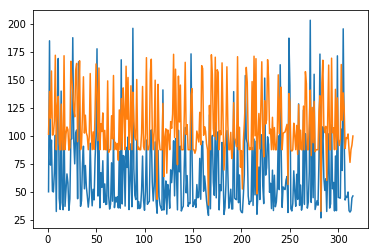

In [24]:
model = cnn()
model.compile(optimizer='adam', loss='msle')
model.summary()
a=model.fit(x6, y6, epochs=1, batch_size=10,verbose=1)

x_input = x1
yhat = model.predict(x_input, verbose=1)


yhat=yhat.reshape(1,-1)
y1=y1.reshape(1,-1)
print(yhat.shape)
print(y1.shape)
x_line= np.linspace(1,len(yhat[0]),len(yhat[0]))

plt.figure(1)
plt.plot(x_line,yhat[0],x_line,y1[0])

315/315 [==============================] - 9s 30ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 7, 25600, 1)       0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, 7, 6396, 10)       210       
_________________________________________________________________
batch_normalization_17 (Batc (None, 7, 6396, 10)       40        
_________________________________________________________________
time_distributed_42 (TimeDis (None, 7, 3198, 10)       0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 7, 798, 5)         505       
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 798, 5)         20        
_________________________________________________________________
time_distributed_44 

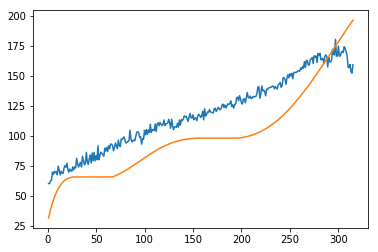

In [41]:
x_input = x4
yhat = model.predict(x_input, verbose=1)
model.summary()

yhat=yhat.reshape(1,-1)
y4=y4.reshape(1,-1)
print(yhat.shape)
print(y4.shape)
x_line= np.linspace(1,len(yhat[0]),len(yhat[0]))

plt.figure(1)
plt.plot(x_line,yhat[0],x_line,y4[0])

In [49]:
a=[]
for i in range(315):
    
    a[i]= abs((y4[i-1]-yhat[i-1])/y4[i-1])*100/315
    

IndexError: list assignment index out of range

In [52]:
print(y4.shape)

(1, 315)


In [44]:
a

In [46]:
print(a.shape)

AttributeError: 'map' object has no attribute 'shape'

In [13]:
x1=x1.reshape(-1,40,512,7,1)
y1=y1.reshape(-1,1)

x4=x4.reshape(-1,40,512,7,1)
y4=y4.reshape(-1,1)

x6=x6.reshape(-1,40,512,7,1)
y6=y6.reshape(-1,1)


In [ ]:
model = ConvLstm()
model.compile(optimizer='adam', loss='msle')
model.fit(x6, y6, epochs=2, batch_size=10,verbose=1)

x_input = x1
yhat = model.predict(x_input, verbose=1)
model.summary()

yhat=yhat.reshape(1,-1)
y1=y1.reshape(1,-1)
print(yhat.shape)
print(y1.shape)
x_line= np.linspace(1,len(yhat[0]),len(yhat[0]))

plt.figure(1)
plt.plot(x_line,yhat[0],x_line,y1[0])

building model...
Epoch 1/2
315/315 [==============================] - 382s 1s/step - loss: 23.0079
Epoch 2/2
100/315 [========>.....................] - ETA: 4:18 - loss: 23.0151

In [ ]:
model = Sequential()
input_shape = (data1.shape[0], data1.shape[1], data1.shape[2], 1)
model.add(ConvLSTM2D(16, kernel_size=(3, 3), activation='sigmoid', padding='same',input_shape=input_shape,return_sequences=True))
model.add(ConvLSTM2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same',return_sequences=True))
model.compile(loss='mse', optimizer='adam')

model.fit(X_train, Y_train, 
      batch_size=1, epochs=10, verbose=1)

y_predict = model.predict(X_train)
y_predict = y_predict.reshape(data1.shape[0], data1.shape[1], data1.shape[2])
slope, intercept, r_value, p_value, std_err = stats.linregress(data2[0,:,:].reshape(-1), y_predict[0,:,:].reshape(-1))
print (r_value**2)


In [73]:

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(40,640,7,1)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')